In [33]:
# import os
import torch
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt

from torch import nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from torchinfo import summary
from torch.utils.data import DataLoader

from models.deepLOB.deepLOB_model import Deeplob
from models.transLOB import TransLOB
from utils.fi2010_loader import load_fi2010#, Dataset_fi2010
from utils.training import train_validate
from utils.evaluation import evaluate
from utils.plots import plot_training_history, plot_label_distributions

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [31]:
dataset_type='fi2010'
normalization = 'Zscore'
lighten = False
feature_size = 40

T = 100
k = 4
stock = [0, 1, 2, 3, 4]
train_val_ratio = 0.8

train_days = [7]
test_days = [8,9,10]

batch_size= 128
num_workers= 4

In [36]:
dataset_train, dataset_val, dataset_test = load_fi2010(train_val_ratio, normalization, stock, 
                                                       train_days, test_days, T, k, True)

print(f"Training Data Size : {dataset_train.__len__()}")
print(f"Validation Data Size : {dataset_val.__len__()}")
print(f"Test Data Size : {dataset_test.__len__()}")

train_loader = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

Loading:  Train_Dst_NoAuction_ZScore_CF_7.txt
Loading:  Test_Dst_NoAuction_ZScore_CF_7.txt
Loading:  Test_Dst_NoAuction_ZScore_CF_8.txt
Loading:  Test_Dst_NoAuction_ZScore_CF_9.txt
Training Data Size : 203404
Validation Data Size : 50851
Test Data Size : 138102


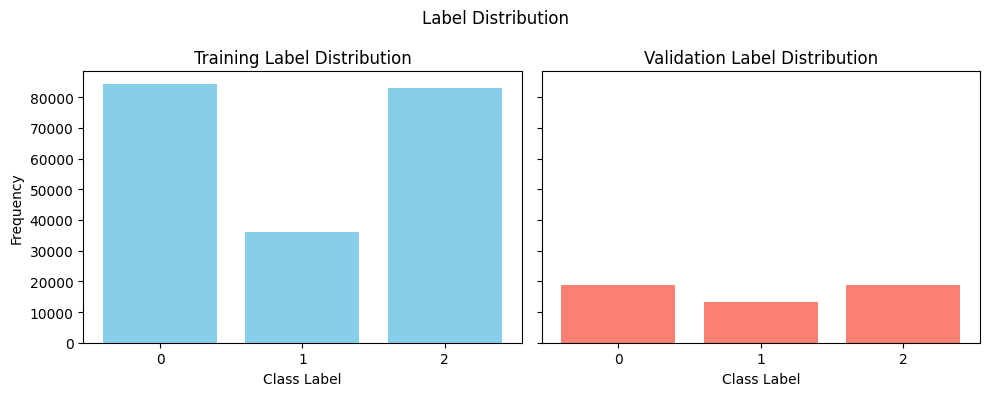

In [43]:
plot_label_distributions(dataset_train, dataset_val)

# DeepLOB

In [38]:
model_deepLOB = Deeplob(lighten=lighten).to(device)
summary(model_deepLOB, (1, 1, 100, feature_size))

Layer (type:depth-idx)                   Output Shape              Param #
Deeplob                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 32, 94, 20]           --
│    └─Conv2d: 2-1                       [1, 32, 100, 20]          96
│    └─LeakyReLU: 2-2                    [1, 32, 100, 20]          --
│    └─BatchNorm2d: 2-3                  [1, 32, 100, 20]          64
│    └─Conv2d: 2-4                       [1, 32, 97, 20]           4,128
│    └─LeakyReLU: 2-5                    [1, 32, 97, 20]           --
│    └─BatchNorm2d: 2-6                  [1, 32, 97, 20]           64
│    └─Conv2d: 2-7                       [1, 32, 94, 20]           4,128
│    └─LeakyReLU: 2-8                    [1, 32, 94, 20]           --
│    └─BatchNorm2d: 2-9                  [1, 32, 94, 20]           64
├─Sequential: 1-2                        [1, 32, 88, 10]           --
│    └─Conv2d: 2-10                      [1, 32, 94, 10]           2,080
│    └

In [39]:
epochs = 2
learning_rate = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_deepLOB.parameters(), lr=learning_rate)

history = train_validate(model_deepLOB, train_loader, val_loader, optimizer, criterion, epochs, normalization, k, dataset_type, device)

Epoch 1/2, Train Loss: 0.9493, Train Acc: 0.5761, Validation Loss: 0.9766, Validation Acc: 0.5435
Epoch 2/2, Train Loss: 0.8435, Train Acc: 0.6963, Validation Loss: 0.9678, Validation Acc: 0.5599


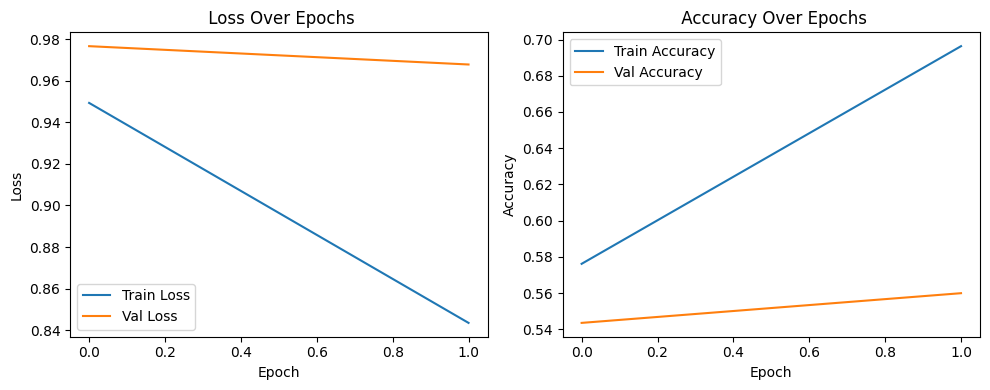

In [40]:
plot_training_history(history)

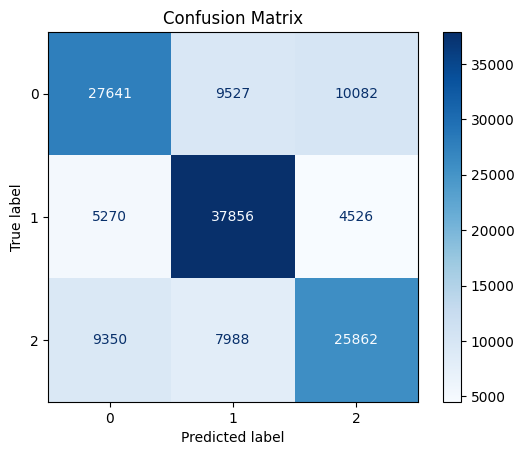

              precision    recall  f1-score   support

           0     0.6541    0.5850    0.6176     47250
           1     0.6837    0.7944    0.7349     47652
           2     0.6390    0.5987    0.6182     43200

    accuracy                         0.6615    138102
   macro avg     0.6589    0.6594    0.6569    138102
weighted avg     0.6596    0.6615    0.6583    138102

Test Accuracy: 0.6615
Test Precision (macro): 0.6589
Test Recall (macro): 0.6594
Test F1 Score (macro): 0.6569


In [42]:
evaluate(model_deepLOB, test_loader, device)

In [ ]:
# from utils.fi2010_loader import __vis_sample_lob__
# __vis_sample_lob__('DecPre')

# TransLOB

In [48]:
dataset_train, dataset_val, dataset_test = load_fi2010(train_val_ratio, normalization, stock, 
                                                       train_days, test_days, T, k, False)

print(f"Training Data Size : {dataset_train.__len__()}")
print(f"Validation Data Size : {dataset_val.__len__()}")
print(f"Test Data Size : {dataset_test.__len__()}")

train_loader = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

Loading:  Train_Dst_NoAuction_ZScore_CF_7.txt
Loading:  Test_Dst_NoAuction_ZScore_CF_7.txt
Loading:  Test_Dst_NoAuction_ZScore_CF_8.txt
Loading:  Test_Dst_NoAuction_ZScore_CF_9.txt
Training Data Size : 203404
Validation Data Size : 50851
Test Data Size : 138102


In [56]:
model_transLOB = TransLOB(
    num_features=feature_size,
    num_classes=3,
    hidden_channels=14,
    d_model=15,
    num_heads=3,
    num_transformer_blocks=2
).to(device)
summary(model_transLOB, (1, 100, feature_size))

Layer (type:depth-idx)                   Output Shape              Param #
TransLOB                                 [1, 3]                    --
├─LOBFeatureExtractor: 1-1               [1, 100, 14]              --
│    └─Conv1d: 2-1                       [1, 14, 100]              1,134
│    └─Conv1d: 2-2                       [1, 14, 100]              406
│    └─Conv1d: 2-3                       [1, 14, 100]              406
│    └─Conv1d: 2-4                       [1, 14, 100]              406
│    └─Conv1d: 2-5                       [1, 14, 100]              406
├─LayerNorm: 1-2                         [1, 100, 14]              28
├─LOBPositionalEncoding: 1-3             [1, 100, 15]              --
├─LOBTransformerBlock: 1-4               [1, 100, 15]              --
│    └─MultiheadAttention: 2-6           [1, 100, 15]              960
│    └─LayerNorm: 2-7                    [1, 100, 15]              30
│    └─Sequential: 2-8                   [1, 100, 15]              --
│    │ 

In [ ]:
epochs = 30
learning_rate= 1e-4
ADAM_B1 = 0.9
ADAM_B2 = 0.999
WEIGHT_DECAY= 1e-5

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_transLOB.parameters(), lr=learning_rate, betas=(ADAM_B1, ADAM_B2), weight_decay=WEIGHT_DECAY)

history = train_validate(model_transLOB, train_loader, val_loader, optimizer, criterion, epochs, normalization, k, dataset_type, device)

Epoch 1/30, Train Loss: 0.8857, Train Acc: 0.5777, Validation Loss: 1.0303, Validation Acc: 0.4632
Epoch 2/30, Train Loss: 0.8766, Train Acc: 0.5843, Validation Loss: 1.0325, Validation Acc: 0.4607
Epoch 3/30, Train Loss: 0.8682, Train Acc: 0.5897, Validation Loss: 1.0162, Validation Acc: 0.4783
Epoch 4/30, Train Loss: 0.8606, Train Acc: 0.5952, Validation Loss: 1.0081, Validation Acc: 0.4859


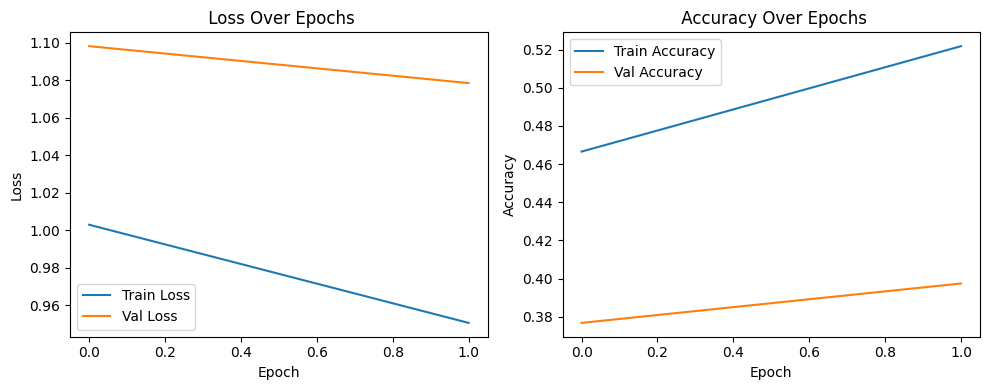

In [51]:
plot_training_history(history)

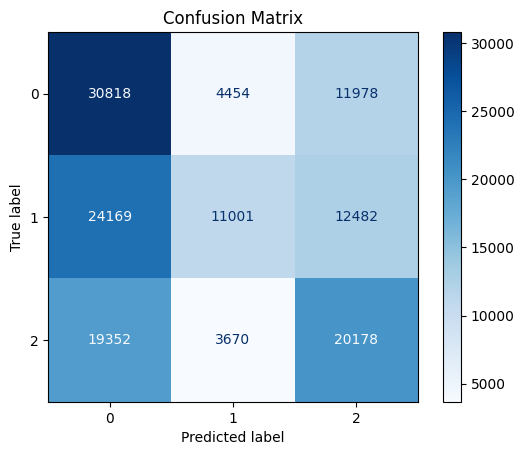

              precision    recall  f1-score   support

           0     0.4146    0.6522    0.5069     47250
           1     0.5752    0.2309    0.3295     47652
           2     0.4520    0.4671    0.4594     43200

    accuracy                         0.4489    138102
   macro avg     0.4806    0.4501    0.4319    138102
weighted avg     0.4817    0.4489    0.4308    138102

Test Accuracy: 0.4489
Test Precision (macro): 0.4806
Test Recall (macro): 0.4501
Test F1 Score (macro): 0.4319


In [52]:
evaluate(model_transLOB, test_loader, device)

In [ ]:
# from tqdm import tqdm
# from datetime import datetime

# def batch_gd(model_id, model, criterion, optimizer, train_loader, val_loader, epochs, name):
#     training_info = {
#         'train_loss_hist': [],
#         'val_loss_hist': [],
#         'train_acc_hist': [],
#         'val_acc_hist': []
#     }

#     best_test_loss = np.inf
#     best_test_epoch = 0
#     device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
#     for iter in tqdm(range(epochs)):
#         model.train()
#         t0 = datetime.now()
#         train_loss = []
#         train_acc = []
#         for inputs, targets in tqdm(train_loader):
#             # move data to GPU
#             inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)
#             # zero the parameter gradients
#             optimizer.zero_grad()
#             # Forward pass
#             outputs = model(inputs)
#             loss = criterion(outputs, targets)
#             # Backward and optimize
#             loss.backward()
#             optimizer.step()
#             train_loss.append(loss.item())
#             tmp_acc = torch.count_nonzero(torch.argmax(outputs, dim = 1) == targets).item()/targets.size(0)
#             train_acc.append(tmp_acc)
#         # Get train loss and test loss
#         train_loss = np.mean(train_loss)
#         train_acc = np.mean(train_acc)

#         model.eval()
#         val_loss = []
#         val_acc = []
#         for inputs, targets in tqdm(val_loader):
#             inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)
#             outputs = model(inputs)
#             loss = criterion(outputs, targets)
#             val_loss.append(loss.item())
#             tmp_acc = torch.count_nonzero(torch.argmax(outputs, dim=1) == targets).item() / targets.size(0)
#             val_acc.append(tmp_acc)
#         val_loss = np.mean(val_loss)
#         val_acc = np.mean(val_acc)

#         # Save losses
#         training_info['train_loss_hist'].append(train_loss)
#         training_info['val_loss_hist'].append(val_loss)
#         training_info['train_acc_hist'].append(train_acc)
#         training_info['val_acc_hist'].append(val_acc)

#         if val_loss < best_test_loss:
#             # torch.save(model, os.path.join(logger.find_save_path(model_id), 'best_val_model.pt'))
#             best_test_loss = val_loss
#             best_test_epoch = iter
#             print('model saved')

#         dt = datetime.now() - t0
#         print(f'Epoch {iter + 1}/{epochs}, '
#               f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc: .4f}, '
#               f'Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc: .4f}, '
#               f'Duration: {dt}, Best Val Epoch: {best_test_epoch}')

#     # torch.save({
#     #     'epoch': epochs,
#     #     'model_state_dict': model.state_dict(),
#     #     'optimizer_state_dict': optimizer.state_dict(),
#     #     'loss': train_loss,
#     # }, os.path.join(logger.find_save_path(model_id), 'checkpoint.pt'))

#     # with open(os.path.join(logger.find_save_path(model_id), 'training_process.pkl'), 'wb') as f:
#     #     pickle.dump(training_info, f)

#     return


In [ ]:
# model_transLOB.eval()

# all_y_true = []
# all_y_pred = []

# with torch.no_grad():
#     for X_batch, y_batch in val_loader:
#         X_batch, y_batch = X_batch.to(device, dtype=torch.float), y_batch.to(device, dtype=torch.int64) 
#         # X_batch, y_batch = X_batch.to(device), y_batch.to(device)

#         outputs = model_transLOB(X_batch)
#         _, y_pred = outputs.max(1)

#         all_y_true.append(y_batch.cpu().numpy())
#         all_y_pred.append(y_pred.cpu().numpy())

# all_y_true = np.concatenate(all_y_true)
# all_y_pred = np.concatenate(all_y_pred)

# cm = confusion_matrix(all_y_true, all_y_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot(cmap="Blues", values_format="d")
# plt.title("Confusion Matrix on Test Set")
# plt.show()

# accuracy = accuracy_score(all_y_true, all_y_pred)
# precision = precision_score(all_y_true, all_y_pred, average='macro')
# recall = recall_score(all_y_true, all_y_pred, average='macro')
# f1 = f1_score(all_y_true, all_y_pred, average='macro')

# print(classification_report(all_y_true, all_y_pred, digits=4))

# print(f"Test Accuracy: {accuracy:.4f}")
# print(f"Test Precision (macro): {precision:.4f}")
# print(f"Test Recall (macro): {recall:.4f}")
# print(f"Test F1 Score (macro): {f1:.4f}")

In [ ]:
# from utils.training import train, validate, train_validate




# train_losses = []
# train_accuracies = []
# val_losses = []
# val_accuracies = []

# best_val_acc = 0

# for epoch in range(epochs):
#     train_loss, train_acc = train(model_transLOB, train_loader, optimizer, criterion, device)
#     val_loss, val_acc = validate(model_transLOB, val_loader, criterion, device)
#     # val_loss, val_acc = validate(model, val_loader, criterion, device)

#     train_losses.append(train_loss)
#     train_accuracies.append(train_acc)
#     val_losses.append(val_loss)
#     val_accuracies.append(val_acc)

#     print(f"Epoch {epoch+1}/{epochs}: "
#           f"Train Loss {train_loss:.4f} | Train Acc {train_acc:.4f} | "
#           f"Val Loss {val_loss:.4f} | Val Acc {val_acc:.4f}")

#     # Save best model
#     if val_acc > best_val_acc:
#         best_val_acc = val_acc
#         torch.save(model_transLOB.state_dict(), './outputs/transLOB/best_transLOB_fi2010.pth')
#         print(f"✅ Saved best model at epoch {epoch+1} with Val Acc {val_acc:.4f}")